In [1]:
using NBInclude
@nbinclude("functions.ipynb")
function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder decoder_last
    println("Done")
    return encoder_μ, encoder_logvar, decoder, decoder_last
    
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end


function load_model_identity_sep(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end



All function imported


load_model_identity_sep (generic function with 1 method)

In [1]:
# pick a image in MNIST to denoise
num = 6
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 48
dir_inco = "trained_GNN/MNIST_unenforced_v2"
encoder_μ_inco, encoder_logvar_inco, W1_inco, W2_inco, W3_inco, Q = load_model_identity_sep(dir_inco, epoch_to_load_inco);
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)

# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, decoder_co, W3_co = load_model_identity(dir_co, epoch_to_load_co);
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)

#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 5000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);

G_inco(z) = Q *relu(W2_inco *relu(W1_inco * z))

G_co(z) = W3_co *decoder_co(z)
z = randn(20)
plot(plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' )), plot(colorview(Gray, reshape(x_true, 28,28)' )) )
# F = dct(diagm(ones(x_dim)),2);
# print("$(subspace_incoherence(F, Q)), $(norm(Q'*Q - I(500), 2))")

UndefVarError: UndefVarError: get_train_loader not defined

-2.8575086451147524, 1.8506722317277784


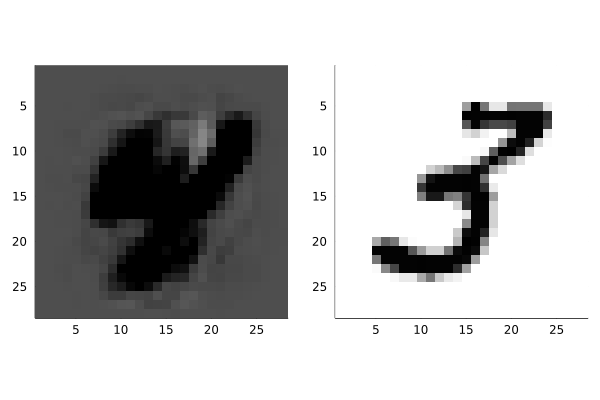

In [113]:
_,s,_, =svd(Flux.params(decoder_co)[2]);
s

_,s,_, =svd(Q);
println("$(minimum(G_inco(rand(20)))), $(maximum(G_inco(z_inco)))")
s

plot(plot(colorview(Gray, reshape(G_inco(rand(20)), 28,28)' )), plot(colorview(Gray, reshape(x_true, 28,28)' )) )


In [127]:
m = 200
F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  
β = 1

# G = Chain(
#     Dense(20, 500, relu, bias = false; init =(out,in) -> β *W1_co + (1-β) * W1_inco),
#     Dense(500, 500, relu, bias = false; init =(out,in) -> β *W2_co + (1-β) * W2_inco),
#     Dense(500, 784, identity, bias = false; init =(out,in) -> β *W3_co + (1-β) * W3_inco),
# )  

y = F_sub * G_inco(z) # measurement vector using subsampled DCT matrix
z_est = randn(k) #initialization for algorithm
z_est = estimated_code(opt, G_inco, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

print("$(norm(z_est - z)), $(norm(z)), $(norm(z_inco))")

sqrt(20)


13.323384753266023, 4.006067961049171, 4.1951423

4.47213595499958

In [5]:
m_list = 10:5:50
z_est_inco_list = zeros(k, length(m_list))
z_est_co_list = zeros(k, length(m_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_inco_list[:,i] = z_est_inco

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_co_list[:,i] = z_est_co
end



┌ Info: Saved animation to 
│   fn = C:\Users\Babhru\AppData\Local\Temp\jl_Wqg3fYW6fp.gif
└ @ Plots C:\Users\Babhru\.julia\packages\Plots\E2187\src\animation.jl:126


Plots.AnimatedGif("C:\\Users\\Babhru\\AppData\\Local\\Temp\\jl_Wqg3fYW6fp.gif")
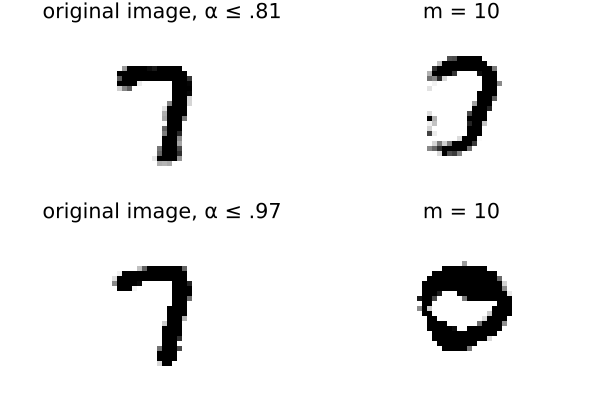

In [6]:
anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end
gif(anim, fps = 1)
# gif(anim, "anim_5.gif", fps = 1)

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


Loading model...Done
Loading model...Done


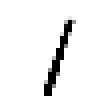

In [11]:


# pick a image in MNIST to denoise
num = 1
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3_inco = load_model_identity(dir_inco, epoch_to_load_inco);
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)


# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, decoder_co, W3_co = load_model_identity(dir_co, epoch_to_load_co);
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)


#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);

G_inco(z) = W3_inco *decoder_inco(z)
G_co(z) = W3_co *decoder_co(z)
colorview(Gray, reshape(G_co(z_co), 28,28)' )




In [12]:
m_list = 10:5:100
z_est_inco_list = zeros(k, length(m_list))
z_est_co_list = zeros(k, length(m_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_inco_list[:,i] = z_est_inco

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_co_list[:,i] = z_est_co
end



┌ Info: Saved animation to 
│   fn = c:\Users\Babhru\Documents\GitHub\GNN_Isometries\anim_1.gif
└ @ Plots C:\Users\Babhru\.julia\packages\Plots\E2187\src\animation.jl:126


Plots.AnimatedGif("c:\\Users\\Babhru\\Documents\\GitHub\\GNN_Isometries\\anim_1.gif")
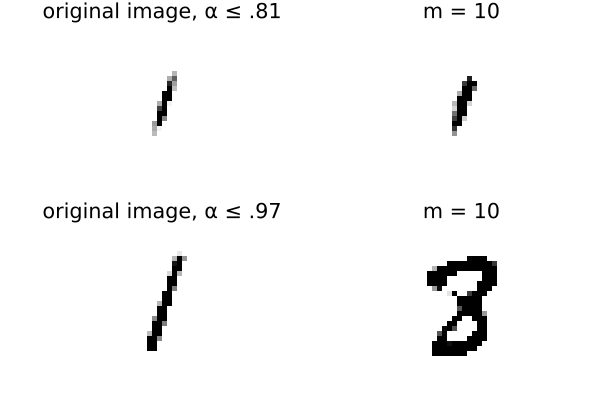

In [13]:
anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end

gif(anim, "anim_$num.gif", fps = 1)

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


Loading model...Done
Loading model...Done


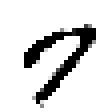

In [32]:


# pick a image in MNIST to denoise
num = 7
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3_inco = load_model_identity(dir_inco, epoch_to_load_inco);
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)


# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, decoder_co, W3_co = load_model_identity(dir_co, epoch_to_load_co);
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)


#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);

G_inco(z) = W3_inco *decoder_inco(z)
G_co(z) = W3_co *decoder_co(z)
colorview(Gray, reshape(G_inco(z_inco), 28,28)' )




In [33]:
m_list = 10:5:100
z_est_inco_list = zeros(k, length(m_list))
z_est_co_list = zeros(k, length(m_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_inco_list[:,i] = z_est_inco

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_co_list[:,i] = z_est_co
end



┌ Info: Saved animation to 
│   fn = c:\Users\Babhru\Documents\GitHub\GNN_Isometries\anim_7.gif
└ @ Plots C:\Users\Babhru\.julia\packages\Plots\E2187\src\animation.jl:126


Plots.AnimatedGif("c:\\Users\\Babhru\\Documents\\GitHub\\GNN_Isometries\\anim_7.gif")
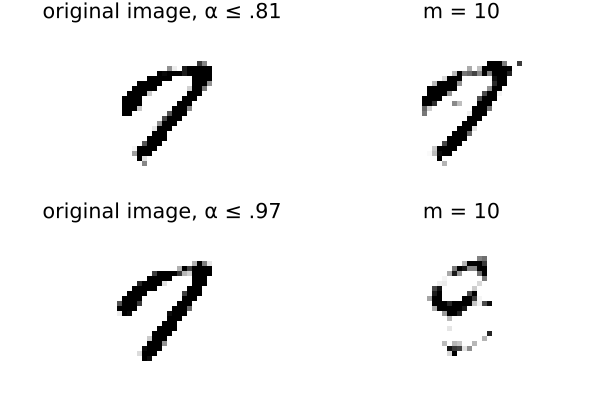

In [34]:
anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end

gif(anim, "anim_$num.gif", fps = 1)

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


Loading model...Done
Loading model...Done


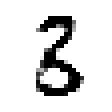

In [7]:


# pick a image in MNIST to denoise
num = 3
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3_inco = load_model_identity(dir_inco, epoch_to_load_inco);
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)


# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, decoder_co, W3_co = load_model_identity(dir_co, epoch_to_load_co);
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)


#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);

G_inco(z) = W3_inco *decoder_inco(z)
G_co(z) = W3_co *decoder_co(z)
colorview(Gray, reshape(G_co(z_co), 28,28)' )




In [8]:
m_list = 10:5:100
z_est_inco_list = zeros(k, length(m_list))
z_est_co_list = zeros(k, length(m_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_inco_list[:,i] = z_est_inco

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_co_list[:,i] = z_est_co
end



┌ Info: Saved animation to 
│   fn = c:\Users\Babhru\Documents\GitHub\GNN_Isometries\anim_3.gif
└ @ Plots C:\Users\Babhru\.julia\packages\Plots\E2187\src\animation.jl:126


Plots.AnimatedGif("c:\\Users\\Babhru\\Documents\\GitHub\\GNN_Isometries\\anim_3.gif")
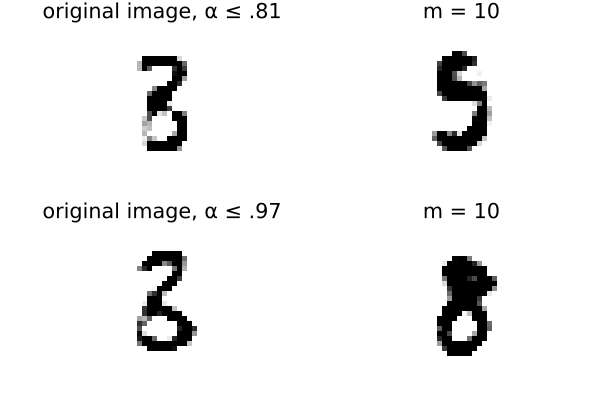

In [9]:
anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end

gif(anim, "anim_$num.gif", fps = 1)

Loading model...Done
Loading model...Done


┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


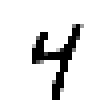

In [38]:


# pick a image in MNIST to denoise
num = 4
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3_inco = load_model_identity(dir_inco, epoch_to_load_inco);
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)


# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, decoder_co, W3_co = load_model_identity(dir_co, epoch_to_load_co);
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)


#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);

G_inco(z) = W3_inco *decoder_inco(z)
G_co(z) = W3_co *decoder_co(z)
colorview(Gray, reshape(G_co(z_co), 28,28)' )




┌ Info: Saved animation to 
│   fn = c:\Users\Babhru\Documents\GitHub\GNN_Isometries\anim_4.gif
└ @ Plots C:\Users\Babhru\.julia\packages\Plots\E2187\src\animation.jl:126


Plots.AnimatedGif("c:\\Users\\Babhru\\Documents\\GitHub\\GNN_Isometries\\anim_4.gif")
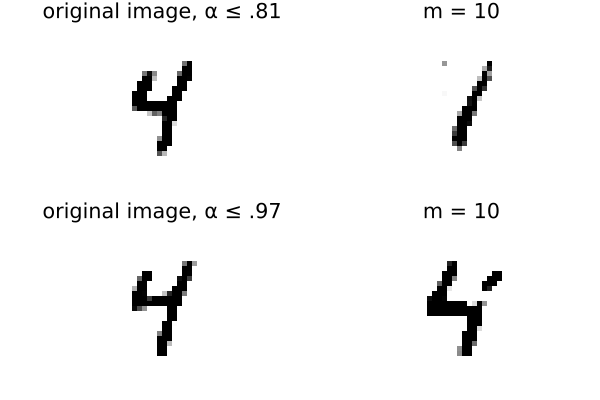

In [39]:
m_list = 10:5:100
z_est_inco_list = zeros(k, length(m_list))
z_est_co_list = zeros(k, length(m_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_inco_list[:,i] = z_est_inco

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_co_list[:,i] = z_est_co
end

anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end

gif(anim, "anim_$num.gif", fps = 1)



In [64]:


# pick a image in MNIST to denoise
num = 4
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)
(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3_inco = load_model_identity(dir_inco, epoch_to_load_inco);
μ1 = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ1 + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco);


┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


Loading model...Done


In [9]:


# pick a image in MNIST to denoise
num = 9
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)
(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3_inco = load_model_identity(dir_inco, epoch_to_load_inco);
μ2 = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ2 + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco);

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


Loading model...Done


In [8]:
norm(z_inco)

4.3862915f0

In [6]:
sqrt(20)

4.47213595499958

In [84]:
Threads.nthreads()

12

In [42]:
sigmoid(0)

0.5